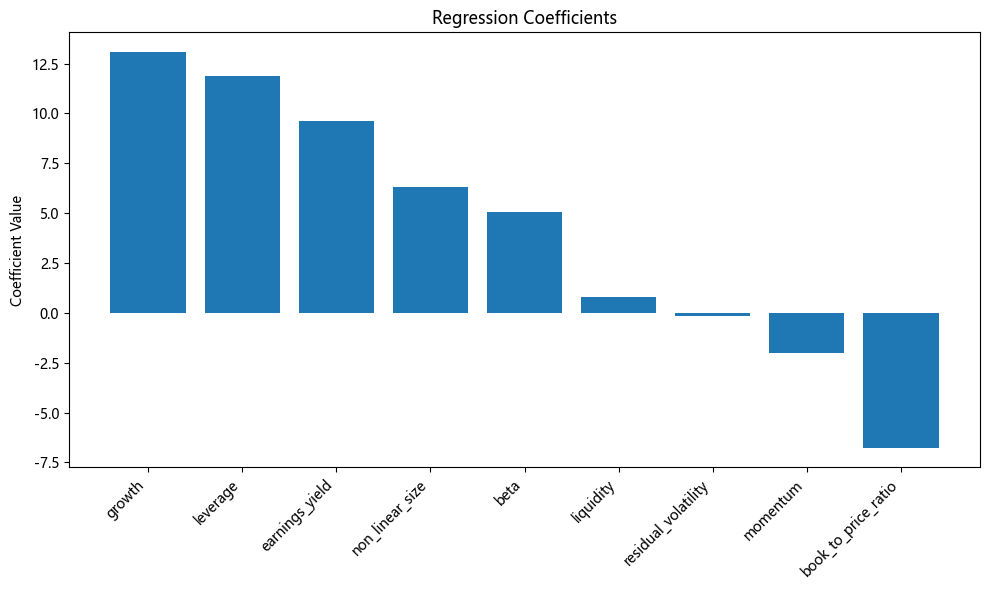

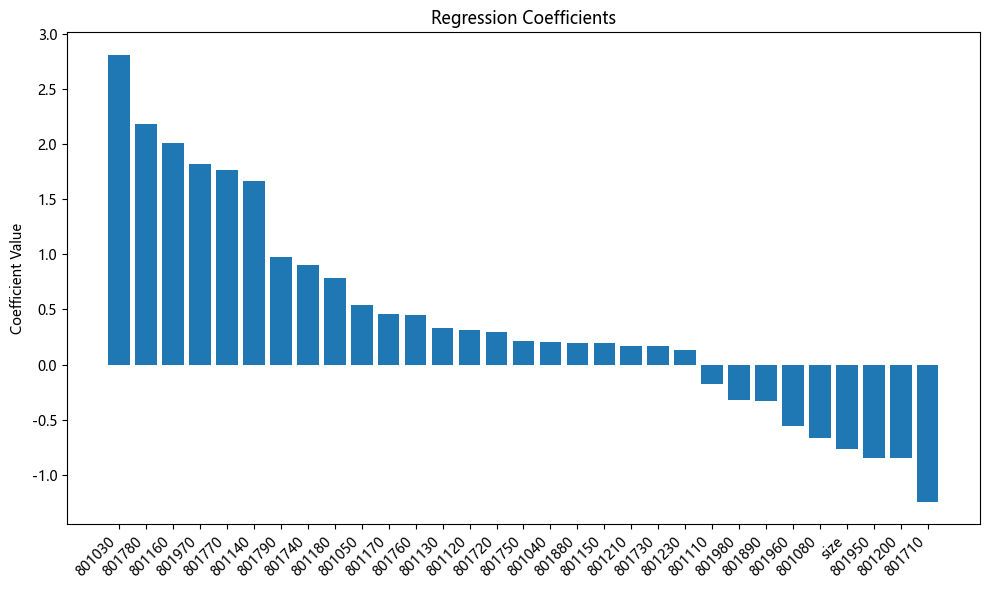

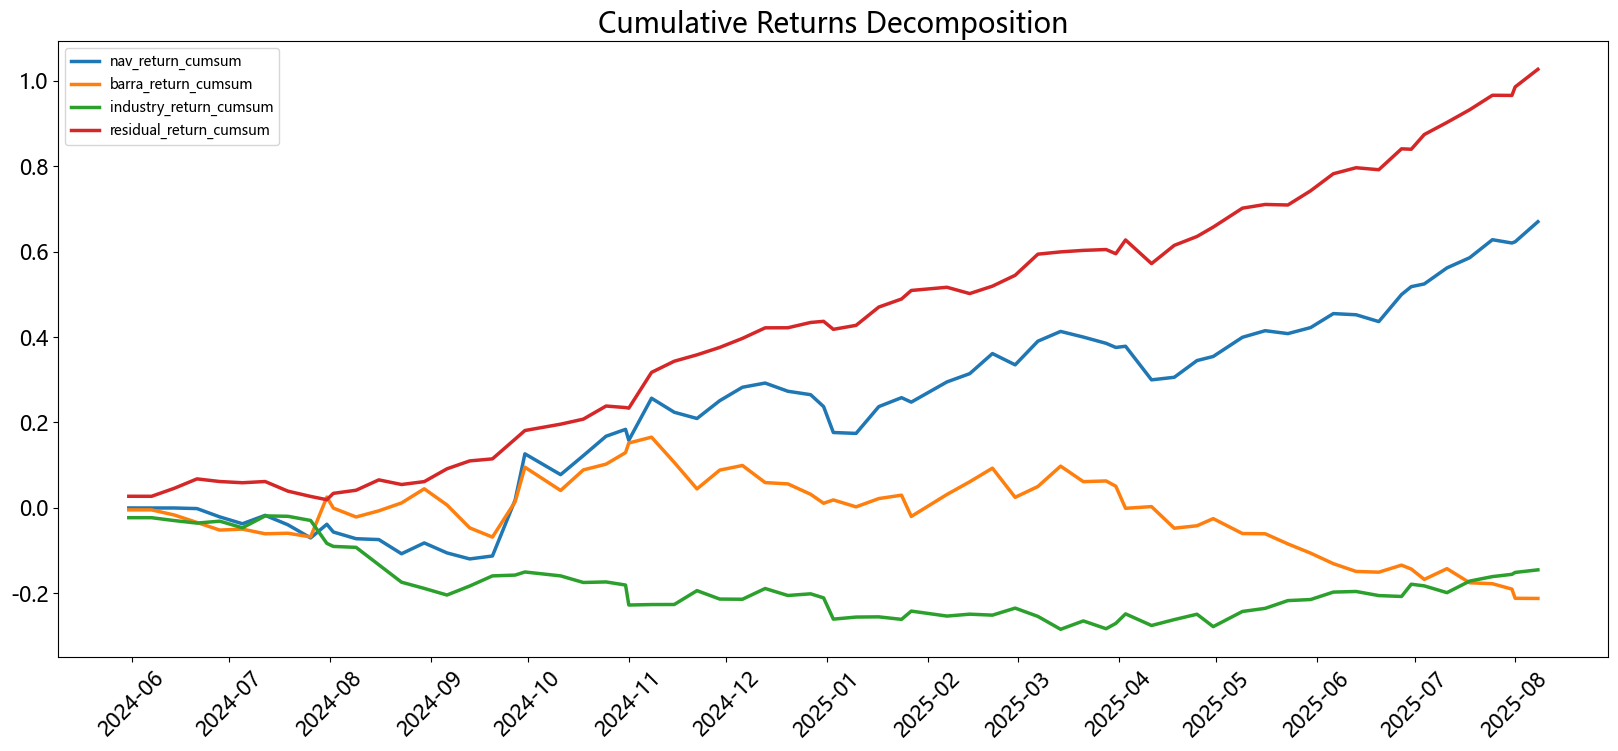

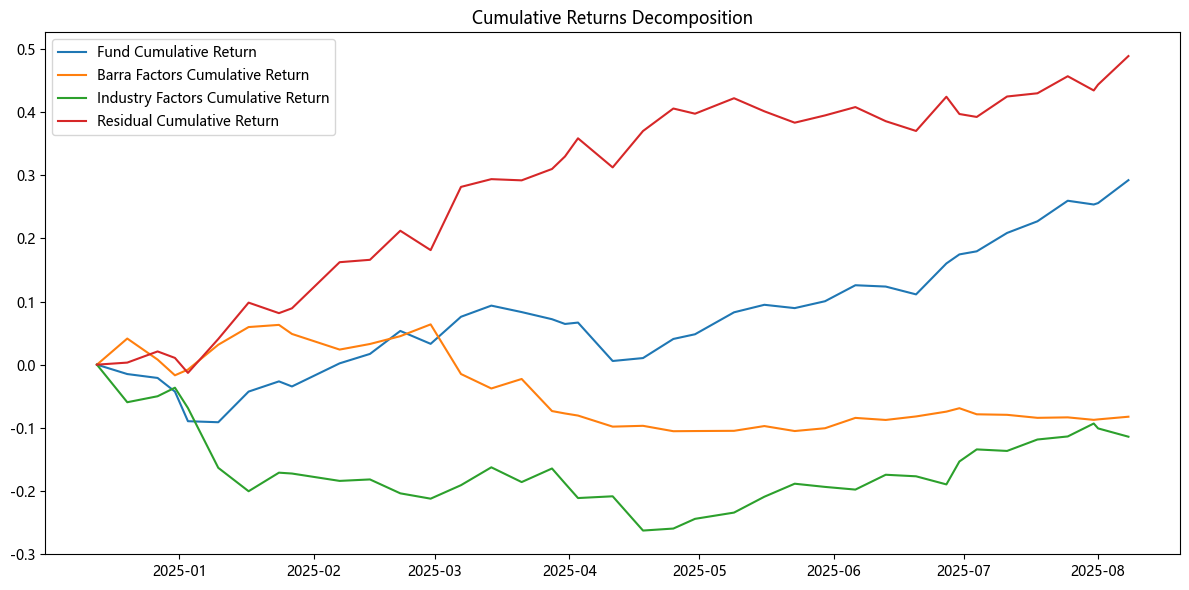

,barra_return,industry_return,nav_return,nav_return_cumsum,barra_return_cumsum,industry_return_cumsum,residual_return_cumsum
date,,,,,,,
2024-12-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-12-20,0.041358,-0.059481,-0.014858,-0.014858,0.041358,-0.059481,0.003264
2024-12-27,-0.032016,0.010061,-0.006284,-0.021049,0.008018,-0.050019,0.020951
2024-12-31,-0.024669,0.014252,-0.022055,-0.042640,-0.016849,-0.036480,0.010688
2025-01-03,0.009191,-0.033423,-0.048986,-0.089537,-0.007813,-0.068683,-0.013041
2025-01-10,0.039665,-0.101648,-0.001785,-0.091162,0.031543,-0.163350,0.040645
2025-01-17,0.027149,-0.044307,0.053389,-0.042640,0.059548,-0.200420,0.098231
2025-01-24,0.003241,0.036769,0.016894,-0.026466,0.062982,-0.171020,0.081572
2025-01-27,-0.013496,-0.001649,-0.008267,-0.034515,0.048636,-0.172387,0.089237


In [7]:
from barra import BarraAnalyse

nav_data_path = r"千衍六和31号净值20250814.xlsx"
factor_data_path = r"factor_return.xlsx"
demo = BarraAnalyse(nav_data_path,factor_data_path)
demo.get_data()
demo.get_style_exposure()
demo.get_barra()
demo.get_barra_rolling()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
nav_data = pd.read_excel("千衍六和31号净值20250814.xlsx")
nav_data.rename(columns={'日期': 'date'}, inplace=True)
nav_data["date"] = pd.to_datetime(nav_data["date"])
nav_data.sort_values(by=['date'], inplace=True)
nav_data["nav_return"] = nav_data["复权净值"]/nav_data["复权净值"].shift(1) - 1
nav_return = nav_data[["date", "nav_return"]]
factor_return = pd.read_excel("factor_return.xlsx")
factor_return["date"] = pd.to_datetime(factor_return["date"])
data = pd.merge(nav_return, factor_return, on='date', how='left')
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [3]:
data

,date,nav_return,country,801010,801030,801040,801050,801080,801110,801120,...,size,beta,momentum,residual_volatility,non_linear_size,book_to_price_ratio,liquidity,earnings_yield,growth,leverage
0,2024-05-31,0.000000,0.007374,-0.004718,-0.010558,-0.011193,-0.011258,0.005494,0.000646,-0.003573,...,-0.001474,0.003212,0.001193,-0.001745,0.001322,-0.000462,0.000803,-0.000477,-0.001175,-0.000903
1,2024-06-07,-0.000100,0.019075,0.008823,0.005101,0.005931,-0.001024,-0.010302,-0.004479,0.001253,...,-0.014699,0.002462,0.002196,-0.005011,-0.007270,0.002063,0.001157,-0.001273,-0.000660,0.002033
2,2024-06-14,0.000000,0.002122,0.001534,-0.008751,0.012711,-0.000630,0.002386,-0.002381,0.005057,...,-0.002046,-0.001180,0.003713,-0.002375,-0.000380,0.000687,0.002840,0.000805,-0.000652,0.000560
3,2024-06-21,-0.001400,-0.002354,0.005113,-0.001521,-0.002377,-0.006778,0.001053,-0.001910,-0.003470,...,0.000036,-0.001896,0.003245,-0.003090,-0.000146,-0.000080,0.001220,-0.000299,0.000239,-0.000253
4,2024-06-28,-0.019429,0.004673,-0.006813,-0.004237,-0.005799,0.009149,0.013653,-0.006658,-0.009457,...,-0.002503,0.000480,0.006692,-0.002926,-0.001276,0.001352,0.004149,0.001026,-0.000278,-0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2025-07-18,0.015240,0.002983,-0.003198,0.006242,0.002799,0.017014,-0.006669,-0.004552,-0.007331,...,0.000431,-0.000483,-0.000104,-0.000330,-0.001245,0.000656,-0.001949,-0.001576,0.000078,-0.000696
65,2025-07-25,0.026553,0.002227,-0.003860,0.000462,-0.007503,-0.003695,0.012335,-0.000787,-0.009747,...,-0.002755,0.000206,0.001933,-0.002664,-0.001375,-0.001860,-0.001508,-0.000540,0.000694,-0.000577
66,2025-07-31,-0.004731,-0.010329,-0.000940,-0.006218,-0.018518,-0.015605,-0.000193,-0.002028,-0.008648,...,0.000230,0.001817,0.002092,0.001420,0.001546,-0.000449,0.000364,-0.001217,-0.000044,-0.001757
67,2025-08-01,0.001790,0.004986,-0.004988,-0.001564,-0.008723,-0.002764,-0.002686,-0.000173,-0.004015,...,-0.005223,-0.000571,-0.001166,-0.001783,-0.001684,-0.000483,-0.001722,0.000480,-0.001039,-0.000722


In [3]:
X = data.drop(columns=['date',"nav_return","country"])
y = data['nav_return']

In [ ]:
model = sm.OLS(y, sm.add_constant(X)).fit()

### 风格暴露

In [4]:
coefficients = model.params.reset_index()
coefficients.rename(columns={"index":"factor", 0:"coefficient"}, inplace=True)

In [5]:
coefficients_barra = coefficients[33:]
coefficients_barra.sort_values(by='coefficient', ascending=False, inplace=True)
coefficients_industry = coefficients[2:33]
coefficients_industry.sort_values(by='coefficient', ascending=False, inplace=True)

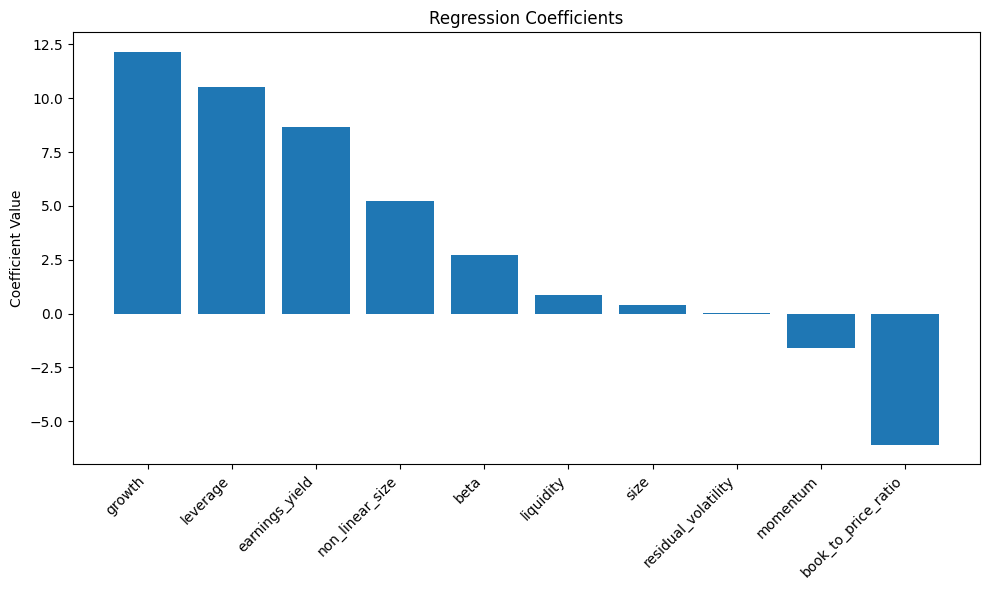

In [6]:
# 创建柱状图
plt.figure(figsize=(10, 6))
plt.bar(coefficients_barra["factor"], coefficients_barra["coefficient"])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Coefficient Value')
plt.title('Regression Coefficients')
plt.tight_layout()
plt.show()

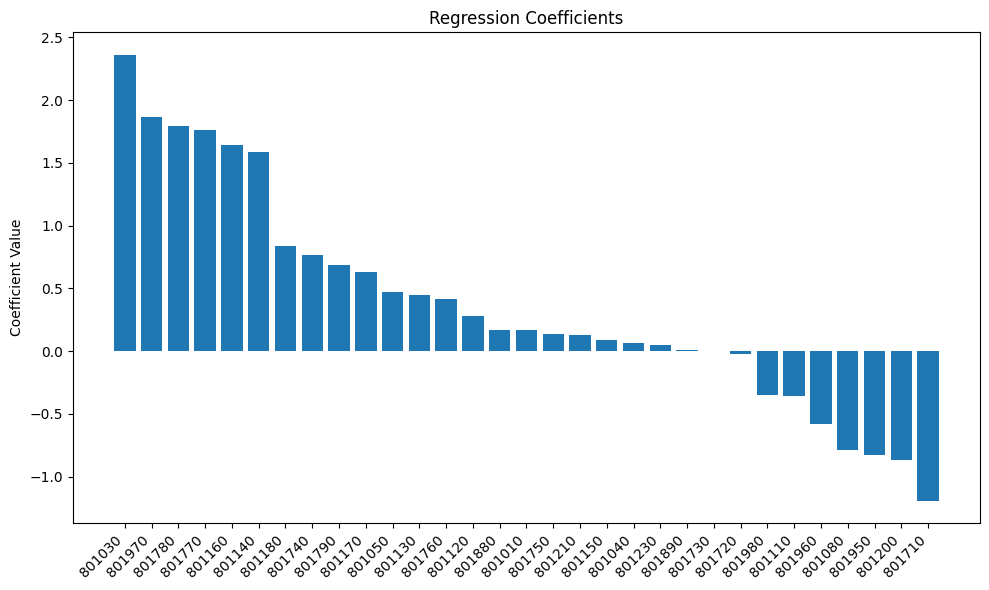

In [7]:
# 创建柱状图
plt.figure(figsize=(10, 6))
plt.bar(coefficients_industry["factor"], coefficients_industry["coefficient"])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Coefficient Value')
plt.title('Regression Coefficients')
plt.tight_layout()
plt.show()

### 业绩归因(一次回归)

In [8]:
industry_beta = model.params[2:33]
barra_beta = model.params[33:]
barra_return = []
industry_return = []
for i in X.index:
    barra_return.append((barra_beta * X.loc[i, barra_beta.index]).sum())
    industry_return.append((industry_beta * X.loc[i, industry_beta.index]).sum())
data_return = data[["date","nav_return"]]
data_return["barra_return"] = barra_return
data_return["industry_return"] = industry_return
data_return.loc[1, ["barra_return","industry_return"]] = 0
data_return["nav_return_cumsum"] = (1 + data_return["nav_return"]).cumprod() - 1
data_return["barra_return_cumsum"] = (1 + data_return["barra_return"]).cumprod() - 1
data_return["industry_return_cumsum"] = (1 + data_return["industry_return"]).cumprod() - 1
data_return["residual_return_cumsum"] = data_return["nav_return_cumsum"] - data_return["barra_return_cumsum"] - data_return["industry_return_cumsum"]
data_return.set_index("date", inplace=True)

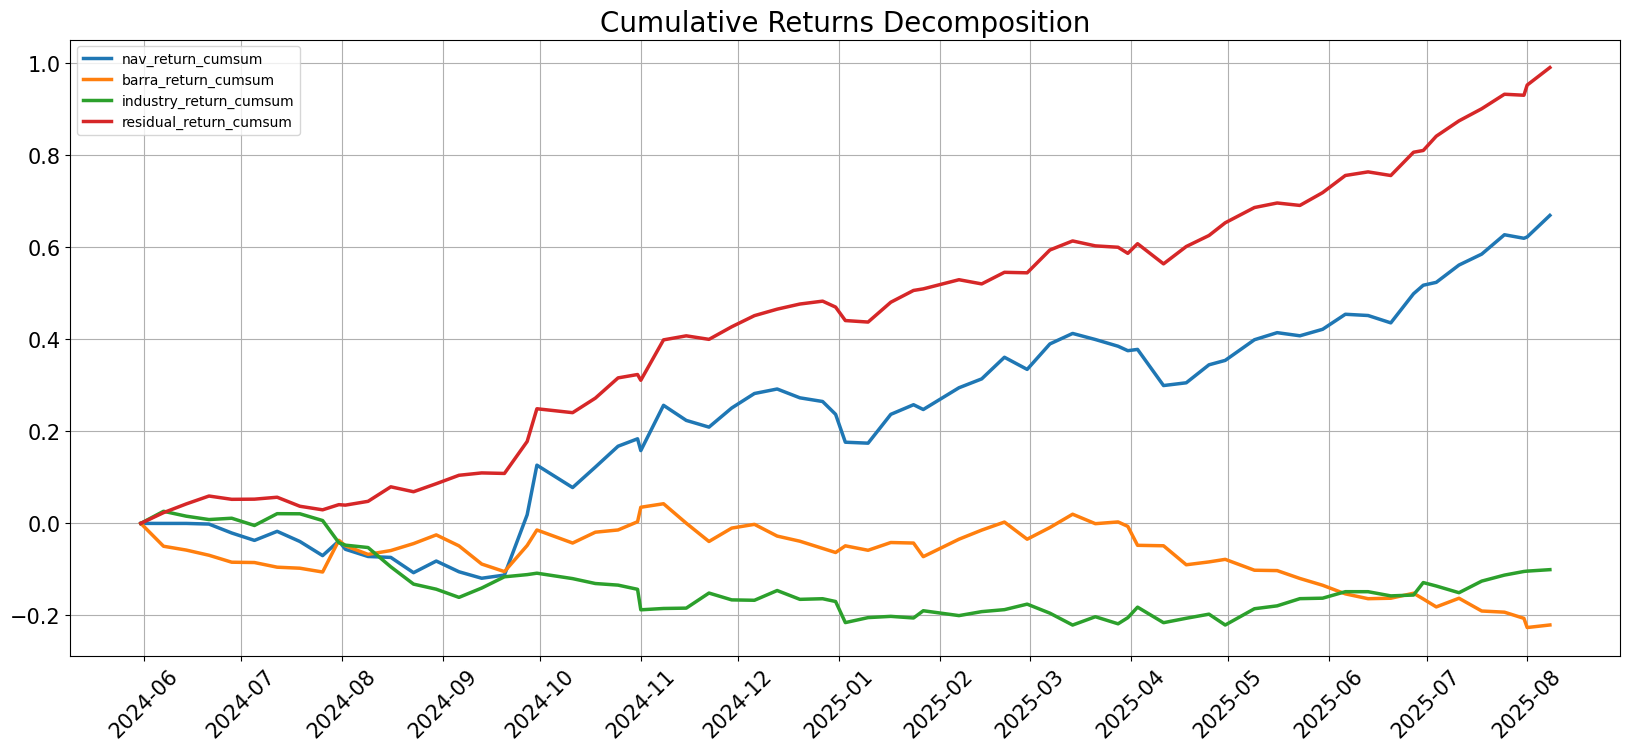

In [9]:
# 画Wind商品指数20日滚动年化波动率图
fig, (ax1) = plt.subplots(nrows=1, figsize=(20, 8))
ax1.plot(data_return["nav_return_cumsum"], label="nav_return_cumsum", linewidth=2.5)
ax1.plot(data_return["barra_return_cumsum"], label='barra_return_cumsum', linewidth=2.5)
ax1.plot(data_return["industry_return_cumsum"], label='industry_return_cumsum', linewidth=2.5)
ax1.plot(data_return["residual_return_cumsum"], label='residual_return_cumsum', linewidth=2.5)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.tick_params(axis="x", rotation=45, labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
ax1.set_title("Cumulative Returns Decomposition", size=20)
ax1.legend(loc="upper left", fontsize=10)

### 业绩归因（滚动回归）

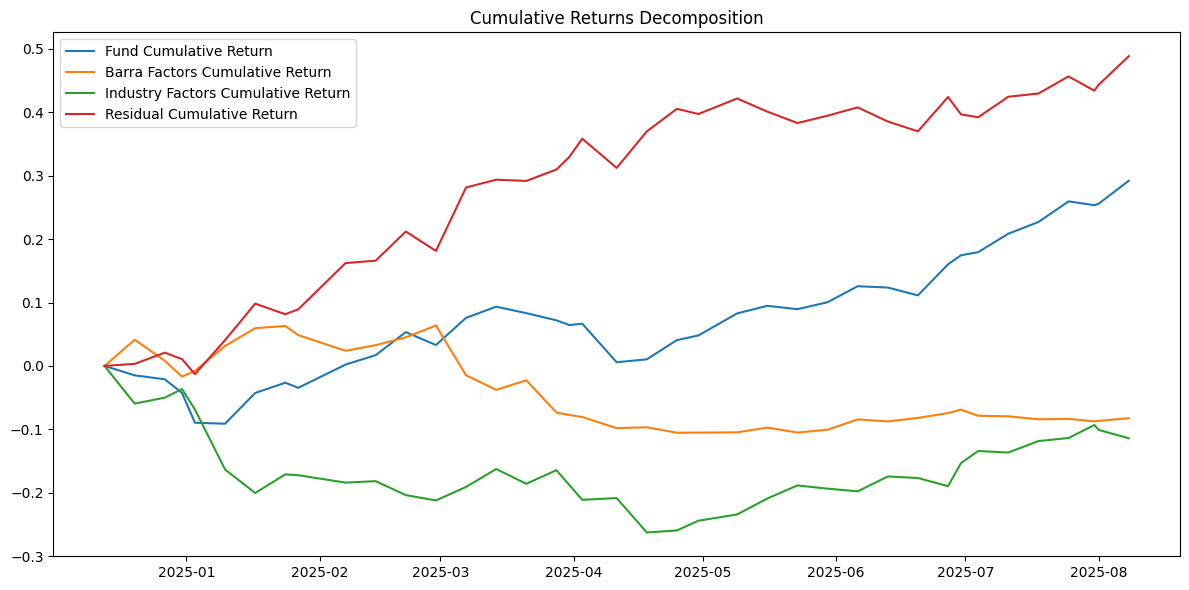

In [16]:
# 假设数据已准备：y是因变量(基金收益)，X是自变量(包含因子和行业)
window = 30
factor_contributions = []
industry_contributions = []

# 创建结果DataFrame
results = pd.DataFrame()

for t in range(window, len(data)):
    # 滚动窗口数据
    y_rolling = y.iloc[t-window:t]
    X_rolling = X.iloc[t-window:t]
    
    # 拟合模型
    model = sm.OLS(y_rolling, sm.add_constant(X_rolling)).fit()
    
    # 获取当前期的因子暴露
    current_X = X.iloc[t-1]
    
    # 计算各类贡献
    barra_beta = model.params[32:]  # 假设33之后是barra因子
    barra_return = (barra_beta * current_X[barra_beta.index]).sum()
    
    beta_industry = model.params[1:32]  # 假设2-33是行业因子
    industry_return = (beta_industry * current_X[beta_industry.index]).sum()
    
    # 存储结果
    factor_contributions.append(barra_return)
    industry_contributions.append(industry_return)

# 转换为Series
results["barra_return"] = factor_contributions
results["industry_return"] = industry_contributions
results["nav_return"] = y[window:].reset_index(drop=True)

results.loc[0, ["nav_return", "barra_return","industry_return"]] = 0

# 累计收益计算
results["nav_return_cumsum"] = (1 + results["nav_return"]).cumprod() - 1
results["barra_return_cumsum"] = (1 + results["barra_return"]).cumprod() - 1
results["industry_return_cumsum"] = (1 + results["industry_return"]).cumprod() - 1
results["residual_return_cumsum"] = results["nav_return_cumsum"] - results["barra_return_cumsum"] - results["industry_return_cumsum"]
results.index = data[30:]["date"]
# 绘图
plt.figure(figsize=(12, 6))
plt.plot(results.index, results["nav_return_cumsum"], label="Fund Cumulative Return")
plt.plot(results.index, results["barra_return_cumsum"], label="Barra Factors Cumulative Return")
plt.plot(results.index, results["industry_return_cumsum"], label="Industry Factors Cumulative Return")
plt.plot(results.index, results["residual_return_cumsum"], label="Residual Cumulative Return")
plt.legend()
plt.title("Cumulative Returns Decomposition")
plt.tight_layout()
plt.show()